# Orthogonalizing Alpha Model Views - OLS Regression Factor Study

Here, we replicate multiple signal formation techniques deployed by the largest firms in quantitative trading.

This is done with synthetic data to emphasize the process behind forming quantitative portfolios from raw signals.

We apply signal formation to industry/dollar/beta neutral portfolios in a sequential, cell-by-cell manner.

We then aggregate this functionality across several functions to modularize this process for a quantitiatve trading infrastructure.

In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [3]:
# Generate sample data
np.random.seed(1)
num_stocks = 50
num_industries = 5

data = {
    'Stock': [f'Stock_{i}' for i in range(num_stocks)],
    'Z_Score': np.random.randn(num_stocks),
    'Industry': np.random.randint(0, num_industries, num_stocks),
    'ExAnte_Beta': np.random.uniform(0.5, 1.5, num_stocks)
}

df = pd.DataFrame(data)
df.head()

,Stock,Z_Score,Industry,ExAnte_Beta
0,Stock_0,1.624345,0,1.190897
1,Stock_1,-0.611756,3,1.497323
2,Stock_2,-0.528172,4,0.672341
3,Stock_3,-1.072969,3,0.637136
4,Stock_4,0.865408,4,1.432595


In [3]:
# Create industry dummy variables to form industry/beta relationships
industry_dummies = pd.get_dummies(df['Industry'], prefix='Industry')
industry_dummies.head()

,Industry_0,Industry_1,Industry_2,Industry_3,Industry_4
0,1,0,0,0,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,0,0,1,0
4,0,0,0,0,1


In [4]:
# Create interaction terms: ExAnte_Beta * Industry_Dummies
interaction_terms = pd.DataFrame(index=industry_dummies.index, columns=industry_dummies.columns)
for i, beta in df['ExAnte_Beta'].items():
    interaction_terms.loc[i] = industry_dummies.iloc[i] * beta

interaction_terms.head()

,Industry_0,Industry_1,Industry_2,Industry_3,Industry_4
0,1.190897,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.497323,0.0
2,0.0,0.0,0.0,0.0,0.672341
3,0.0,0.0,0.0,0.637136,0.0
4,0.0,0.0,0.0,0.0,1.432595


In [5]:
# Regress Z_score views on interaction terms to capture how much our view is explained by industry-specific market factors

# Run OLS regression
X = sm.add_constant(interaction_terms)
y = df['Z_Score']

model = sm.OLS(y,  X.astype(float)).fit()

# Orthogonal alpha model views
residuals = model.resid

residuals.head()

0    1.275207
1    0.163388
2   -0.141346
3   -0.249050
4    0.717135
dtype: float64

Text(0.5, 1.0, 'Orthogonalized Alpha Model Weights')

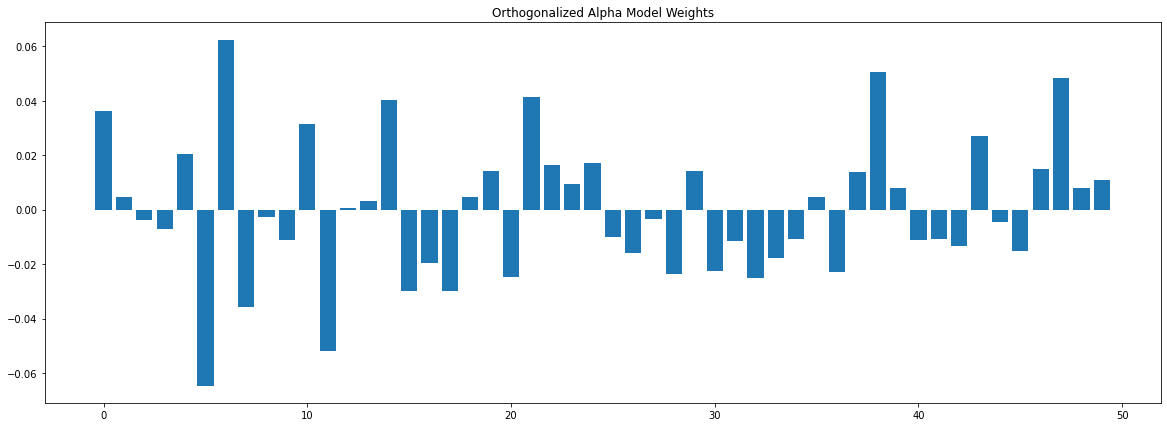

In [6]:
# Get weights from alpha model orthogonalized views
alpha_model_weights = residuals / np.sum(np.abs(residuals))

# Ensure dollar-neutrality
assert -1e-10 < alpha_model_weights.sum() < 1e-10

# Visualize
plt.figure(figsize = (20, 7))
plt.bar(alpha_model_weights.index, alpha_model_weights)
plt.title("Orthogonalized Alpha Model Weights")

# Modularizing Alpha Orthogonalization

This sections creates a series of functions to convert signal views to tradable portfolio weights. These weights can then be scaled to target a given volatilty.

In [227]:
# -------------------------------------------- Alpha Model Functions -------------------------------------------- 

def rank(signal: pd.Series):
    """
    Cross-sectionally ranks alpha signal.
    
    Parameters:
        signal (pd.Series or np.ndarray): Series of alpha signals.
        
    Returns:
        pd.Series or np.ndarray: Ranked signal.
    """

    # If pd.Series, maintain indices/names
    if type(signal) == pd.Series:
        ranked_signal = signal.rank()        
    else:
        ranked_signal = np.argsort(signal)

    return ranked_signal

def quantiles(signal: pd.Series, q = .1):
    """
    Isolates values in the bottom and top quantiles of a signal.
    
    Parameters:
        signal (pd.Series): Series of alpha signals.
        q (float, optional): Quantile threshold (default: 0.1).
        
    Returns:
        pd.Series: Signal with values outside the quantiles set to NaN.
    """

    lower_quantile = np.quantile(signal, q=q)
    upper_quantile = np.quantile(signal, q=1-q)
    
    quantile_signal = signal.where((signal < lower_quantile) | (signal > upper_quantile)).dropna()

    return quantile_signal

def z_score(signal: pd.Series):
    """
    Calculates the z-score of a signal.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate Z-scores for.
        
    Returns:
        pd.Series: Z-scores of the input signal.
    """
    
    z_score = (signal - np.mean(signal)) / np.std(signal)

    return z_score

def ranked_signal_z_score(signal: pd.Series):
    """
    Calculates z-scores for a ranked signal and ensures dollar-neutrality.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate Z-scores for.
        
    Returns:
        pd.Series: Z-scores of the ranked signal.
        
    Raises:
        AssertionError: If the sum of Z-scores is not close to zero (dollar-neutrality check).
    """

    # Rank signals
    ranked_signal = rank(signal)

    # Standardize ranked signals
    z_score_signal = z_score(ranked_signal)

    # Check for dollar-neutrality
    assert -1e-10 < z_score_signal.sum() < 1e-10

    # Dollar-neutral alpha model views
    return z_score_signal

def intra_industry_rank(signal: pd.Series, industry: pd.Series):
    """
    Computes intra-industry cross-sectional ranks for a signal.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate intra-industry ranks for.
        industry (pd.Series): Series indicating the industry of each observation.
        
    Returns:
        pd.Series: Intra-industry ranks of the signal.
    """
    # Create intra-industry ranked signals
    ranked_signal = signal.groupby(industry).rank()

    return ranked_signal

def intra_industry_mean(signal: pd.Series, industry: pd.Series):
    """
    Calculates intra-industry mean values for a signal.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate intra-industry means for.
        industry (pd.Series): Series indicating the industry of each observation.
        
    Returns:
        pd.Series: Intra-industry mean values of the signal.
    """
    # Calculate intra-industry mean 
    mean = signal.groupby(industry).transform('mean')

    return mean

def intra_industry_std(signal: pd.Series, industry: pd.Series):
    """
    Calculates intra-industry standard deviations for a signal.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate intra-industry standard deviations for.
        industry (pd.Series): Series indicating the industry of each observation.
        
    Returns:
        pd.Series: Intra-industry standard deviations of the signal.
    """
    # Calculate intra-industry standard deviation
    sigma = signal.groupby(industry).transform('std')

    return sigma

def intra_industry_quantiles(signal: pd.Series, industry: pd.Series, q=0.1):
    """
    Isolates values in the bottom and top quantiles of a signal within each industry.
    
    Parameters:
        signal (pd.Series): Series of the signal to isolate quantiles for.
        industry (pd.Series): Series indicating the industry of each observation.
        q (float, optional): Quantile threshold (default: 0.1).
        
    Returns:
        pd.Series: Intra-industry signal with values outside the quantiles set to NaN.
    """
    # Group data by industry
    industry_grouped_signal = signal.groupby(industry)
    
    # Calculate quartile values for each industry
    lower_quantiles = industry_grouped_signal.transform(lambda x: np.quantile(x, q))
    upper_quantiles = industry_grouped_signal.transform(lambda x: np.quantile(x, (1 - q)))
    
    # Isolate values in the bottom and top quantiles within each industry
    quantile_signal = signal.where((signal <= lower_quantiles) | (signal >= upper_quantiles)).dropna()

    return quantile_signal


def intra_industry_z_score(signal: pd.Series, industry: pd.Series):
    """
    Calculates industry-neutral Z-scores for a raw signal and ensures dollar-neutrality.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate Z-scores for.
        industry (pd.Series): Series indicating the industry of each stock.
        
    Returns:
        pd.Series: Industry-neutral Z-scores of the signal.
        
    Raises:
        AssertionError: If the sum of Z-scores within each industry is not close to zero (dollar-neutrality check).
    """

    # Calculate intra-industry ranked signal mean and standard deviation
    industry_mean = intra_industry_mean(signal=signal, industry=industry)
    industry_sigma = intra_industry_std(signal=signal, industry=industry)

    # Standardize intra-industry ranked signals
    z_score = (signal - industry_mean) / industry_sigma

    # Check for dollar-neutrality
    assert -1e-10 < z_score.groupby(industry).sum().sum() < 1e-10

    # Industry dollar-neutral alpha model views
    return z_score 

def intra_industry_ranked_signal_z_score(signal: pd.Series, industry: pd.Series):
    """
    Calculates industry-neutral Z-scores for a ranked signal and ensures dollar-neutrality.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate Z-scores for.
        industry (pd.Series): Series indicating the industry of each stock.
        
    Returns:
        pd.Series: Industry-neutral Z-scores of the ranked signal.
        
    Raises:
        AssertionError: If the sum of Z-scores within each industry is not close to zero (dollar-neutrality check).
    """

    # Create intra-industry ranked signals
    ranked_signal = intra_industry_rank(signal=signal, industry=industry) 

    # Get the intra-industry z-score of ranked signals
    z_score = intra_industry_z_score(signal=ranked_signal, industry=industry)

    # Check for dollar-neutrality
    assert -1e-10 < z_score.groupby(industry).sum().sum() < 1e-10

    # Industry dollar-neutral alpha model views
    return z_score


def beta_neutralize(views: pd.Series, betas: pd.Series) -> pd.Series:
    """
    Orthogonalizes alpha model to the market factor. Transforms alpha 
    model views to beta-neutralized weights based on stock-level betas.   
    These alpha weights can then be scaled to target desired level of vol.

    This function will eventually be extended to orthogonalize alpha model 
    to other market factors (e.g., Fama-French factors).
    
    Parameters:
        views (pd.Series): Series of your alpha model views.
        betas (pd.Series): Series of ex-ante stock-level betas.
        
    Returns:
        pd.Series: Alpha weights for beta-neutralized views.
    """

    # Preprocess data
    X = sm.add_constant(betas).astype(float)
    y = views.astype(float)

    # Regress model views on stock-level betas
    model = sm.OLS(endog=y, exog=X).fit() 
    alpha = model.params[0]
    beta = model.params[1]
    resid = y - (beta * X['ExAnte_Beta'] + alpha) 
    
    # Orthogonalize views to create your alpha weights
    alpha_views = resid
    w = alpha_views / np.sum(np.abs(alpha_views))

    # Ensure dollar neturality
    assert  -1e-10 < np.sum(w) < 1e-10

    return w

def industry_beta_neutralize(views: pd.Series, industry: pd.Series, betas: pd.Series):
    """
    Creates industry beta-neutral alpha weights for views based on stock-level betas and industries.
    Views are expected to be industry dollar-neutral before passed to this function... if views are not
    dollar neutral beforehand, there is no guaruntee that weights will be industry-dollar neutral.
    
    Parameters:
        views (pd.Series): Series of your alpha model views.
        industry (pd.Series): Series indicating the industry of each stock.
        betas (pd.Series): Series of ex-ante stock-level betas.
        
    Returns:
        pd.Series: Alpha weights for industry beta-neutralized views.
    """

    # Create industry dummy variables
    industry_dummies = pd.get_dummies(industry, prefix='Industry')

    print(industry_dummies.shape, betas.shape)
    
    # Create interaction terms: ExAnte_Beta * Industry_Dummies
    interaction_terms = pd.DataFrame(index=industry_dummies.index, columns=industry_dummies.columns)
    for i, beta in betas.items():
        interaction_terms.loc[i] = industry_dummies.loc[i] * beta

    # Beta Neutralize beta within industry
    w = beta_neutralize(views=views, betas=interaction_terms)

    return w

def plot_weights(w: pd.Series, title=None):

    plt.figure(figsize=(20, 5))
    plt.bar(w.index, w)
    if title:
        plt.title(title)
    plt.show()

Run the previous simulation on a raw signal while leveragin new modularized infrastructure

In [204]:
# Generate sample data
np.random.seed(1)
num_stocks = 50
num_industries = 5

# Generate synthetic data including the raw signal instead of the Z-Scored signal
data = {
    'Stock': [f'Stock_{i}' for i in range(num_stocks)],
    'Signal': np.random.randn(num_stocks),
    'Industry': np.random.randint(0, num_industries, num_stocks),
    'ExAnte_Beta': np.random.uniform(0.5, 1.5, num_stocks)
}

df = pd.DataFrame(data)

(50, 5) (50,)
const        -0.944267
Industry_0    1.202773
Industry_1    0.910758
Industry_2    1.065030
Industry_3    1.120132
Industry_4    0.832106
dtype: float64


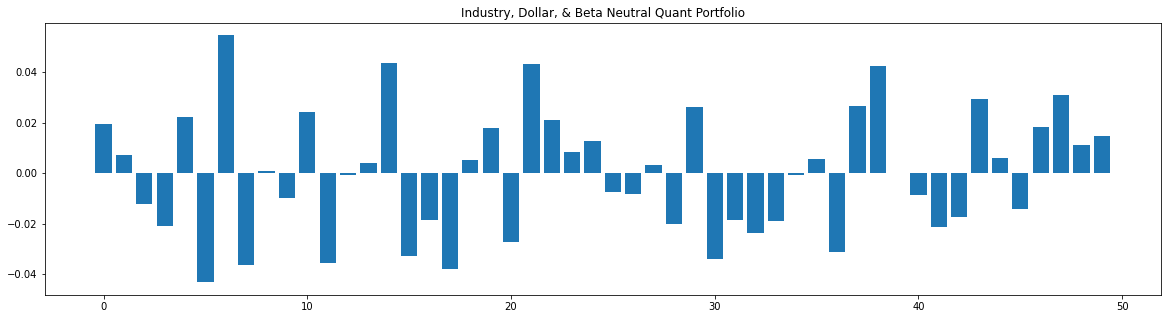

0    0.019340
1    0.007194
2   -0.012172
3   -0.020727
4    0.022303
dtype: float64

In [205]:
# Industry & Dollar Neutralize Standardized Ranked Alpha Signal
df['Z_score'] = intra_industry_ranked_signal_z_score(signal=df['Signal'], industry=data['Industry'])

# Convert Z-Scored signal into beta dollar-neutral portfolio weights
w = industry_beta_neutralize(views=df['Z_score'], industry=df['Industry'], betas=df['ExAnte_Beta'])
plot_weights(w, title="Industry, Dollar, & Beta Neutral Quant Portfolio")
w.head()

Different Signal Transformation Alpha Model - Non Industry Neutral Quantile +  Z-Score + Dollar/Beta Neutral

    const  ExAnte_Beta
0     1.0     1.190897
3     1.0     0.637136
5     1.0     1.196818
6     1.0     0.566000
10    1.0     1.211525
11    1.0     0.624271
14    1.0     0.528306
15    1.0     0.746211
17    1.0     1.038831
20    1.0     0.624173
21    1.0     0.779184
22    1.0     1.085759
24    1.0     1.061030
27    1.0     0.732974
33    1.0     0.636455
36    1.0     0.544552
38    1.0     0.725709
41    1.0     0.512556
43    1.0     1.467276
47    1.0     1.243826
-1.3183898417423734e-16


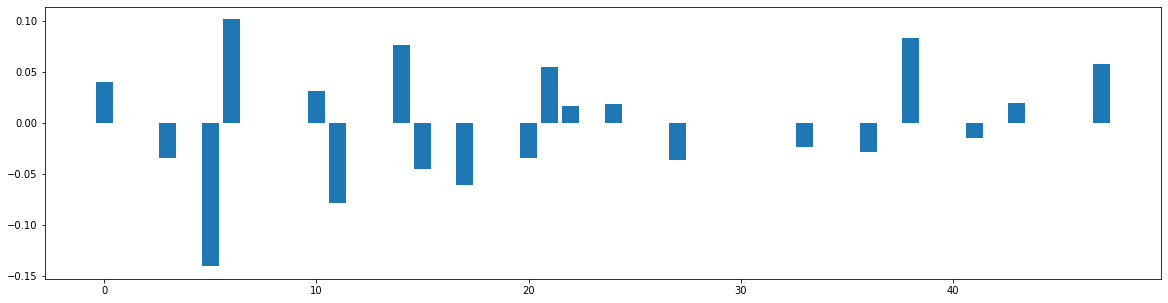

In [228]:
# Get the top and bottm quantiles of signal
new_views = z_score(quantiles(df.Signal, q=0.2))
w = beta_neutralize(new_views, betas=df['ExAnte_Beta'].loc[new_views.index])
plot_weights(w)

In [222]:
w

0     0.040442
3    -0.034575
5    -0.140886
6     0.101515
10    0.031137
11   -0.078895
14    0.076724
15   -0.045507
17   -0.061282
20   -0.034697
21    0.054936
22    0.016498
24    0.018662
27   -0.036772
33   -0.024025
36   -0.028391
38    0.083409
41   -0.014970
43    0.019021
47    0.057656
dtype: float64

Different Signal Transformation Alpha Model - Quantile + Rank + Z-Score + Industry/Beta/Dollar-Neutral

(28, 5) (28,)


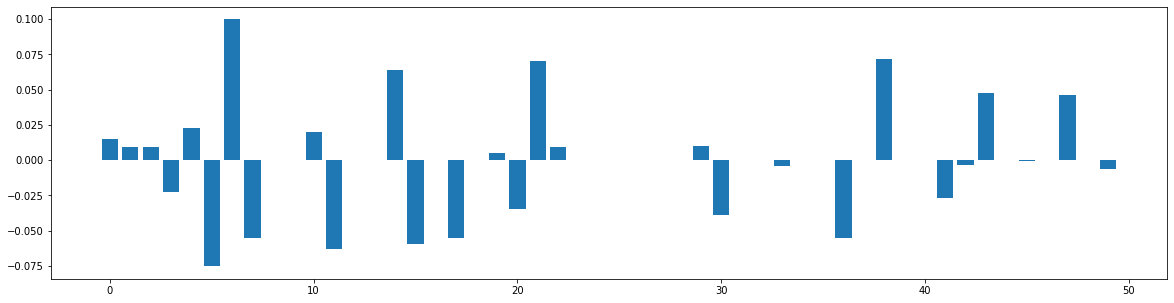

In [172]:
# Get the top and bottm intra-industry quantiles of signal
new_views = intra_industry_quantiles(signal=df.Signal, industry=df.Industry, q=0.25)

# Redifine tradable universe
new_df = df.loc[new_views.index]

# Intra-industry rank the quantiles, then z-score the rank of the quantiles
new_views = intra_industry_ranked_signal_z_score(signal=new_views, industry=new_df .Industry)

# Beta, industry, and dollar-neutralize the remanining portfolio
w = industry_beta_neutralize(views=new_views, industry=new_df['Industry'], betas=new_df['ExAnte_Beta'])

plot_weights(w)

In [195]:
import numpy as np
import pandas as pd
from scipy.stats import t, norm, skewnorm, johnsonsu

def t_stat(signal: pd.Series, df=10):
    """
    Calculates the t-score of a signal based on the Student's t-distribution.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate t-scores for.
        df (int, optional): Degrees of freedom for the t-distribution (default: 10).
        
    Returns:
        pd.Series: t-scores of the input signal.
    """
    mean = np.mean(signal)
    standard_error = np.std(signal, ddof=1) / np.sqrt(len(signal))
    t_stats = (signal - mean) / standard_error
    
    return t_stats

def laplace_score(signal: pd.Series):
    """
    Calculates the Laplace score of a signal based on the Laplace distribution.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate Laplace scores for.
        
    Returns:
        pd.Series: Laplace scores of the input signal.
    """
    median = np.median(signal)
    scale = np.mean(np.abs(signal - median))
    laplace_scores = (signal - median) / scale
    
    return laplace_scores

def skewed_t_score(signal: pd.Series, df=10, skew=0):
    """
    Calculates the skewed t-score of a signal based on the skewed Student's t-distribution.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate skewed t-scores for.
        df (int, optional): Degrees of freedom for the t-distribution (default: 10).
        skew (float, optional): Skewness parameter (default: 0).
        
    Returns:
        pd.Series: Skewed t-scores of the input signal.
    """
    skewed_t_scores = (signal - np.mean(signal)) / (np.std(signal, ddof=1) / np.sqrt(len(signal)))
    skewed_t_scores = skewed_t_scores + skew * (df - 2) / np.sqrt((df - 4) * (1 + skew**2 / (df - 2)))
    
    return skewed_t_scores

def skewed_gaussian_score(signal: pd.Series, skew=0):
    """
    Calculates the skewed Gaussian score of a signal based on the skewed Gaussian distribution.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate skewed Gaussian scores for.
        skew (float, optional): Skewness parameter (default: 0).
        
    Returns:
        pd.Series: Skewed Gaussian scores of the input signal.
    """
    skewed_gaussian_scores = (signal - np.mean(signal)) / np.std(signal, ddof=1)
    skewed_gaussian_scores = skewed_gaussian_scores + skew * (skewed_gaussian_scores**2 - 1)
    
    return skewed_gaussian_scores

def johnson_su_score(signal: pd.Series, a=2, b=2):
    """
    Calculates the Johnson SU score of a signal based on the Johnson SU distribution.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate Johnson SU scores for.
        a (float, optional): Shape parameter 'a' (default: 2).
        b (float, optional): Shape parameter 'b' (default: 2).
        
    Returns:
        pd.Series: Johnson SU scores of the input signal.
    """
    transformed_signal = johnsonsu.cdf(signal, a, b)
    johnson_su_scores = norm.ppf(transformed_signal)
    
    return johnson_su_scores


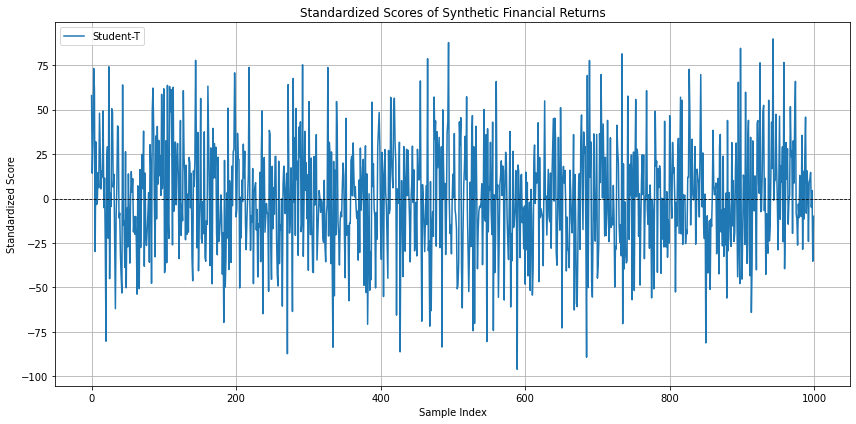

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, skewnorm, johnsonsu
from sklearn.preprocessing import StandardScaler

# Generate synthetic financial returns
np.random.seed(0)
num_samples = 1000



returns = np.random.normal(0, 0.006, num_samples)  # Gaussian distribution
skewed_returns = skewnorm.rvs(-.5, loc=0, scale=0.02, size=num_samples)  # Skewed Gaussian distribution
t_returns = t.rvs(10, loc=0, scale=0.02, size=num_samples)  # Student's t-distribution
# johnson_su_returns = johnsonsu.rvs(0.5, 2, loc=0, scale=0.02, size=num_samples)  # Johnson SU distribution

# Create a DataFrame to store returns
data = {'Gaussian': returns, 'Skewed Gaussian': skewed_returns, 'Student-T': t_returns}
returns_df = pd.DataFrame(data)

# Apply each standardized score function
def apply_standardized_scores(returns, func, **kwargs):
    standardized_scores = func(returns, **kwargs)
    return standardized_scores

scaler = StandardScaler()  # StandardScaler for comparison

standardized_scores = {
    # 'Gaussian': apply_standardized_scores(returns_df['Gaussian'], z_score),
    # 'Skewed Gaussian': apply_standardized_scores(returns_df['Skewed Gaussian'], skewed_gaussian_score, skew=5),
    'Student-T': apply_standardized_scores(returns_df['Gaussian'], t_stat, df=2),
    # 'Johnson SU': apply_standardized_scores(returns_df['Johnson SU'], johnson_su_score, a=0.5, b=2),
    #'Standard Scaler': scaler.fit_transform(returns_df)
}

# Plot the standardized scores
plt.figure(figsize=(12, 6))
for label, scores in standardized_scores.items():
    plt.plot(scores, label=label)
    
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.title('Standardized Scores of Synthetic Financial Returns')
plt.xlabel('Sample Index')
plt.ylabel('Standardized Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
